# Continuation
... after call on Tuesday 12th July
Certain things to test:
- what if we don't select adjacent polygons?
- should we establish a size/area threshold to stop selecting shapes that are _circular_ ('circom')?
    - does this allow to lower the circom back to 0.7?

In [1]:
import numpy as np
import geopandas as gpd
from shapely.ops import polygonize
import matplotlib.pyplot as plt
import folium
import momepy as mm # outputs a 'TqdmWarning'

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
#only for development - to stop DeprecationWarnings from poping up
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# A value is trying to be set on a copy of a slice from a DataFrame.

In [3]:
import rabs_simplify as rabs

In [5]:
#loading data from file
mad = gpd.read_file('/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/data/madrid2062.gpkg')
mad.set_index(['u', 'v', 'key'], inplace=True)
mad.head(3)

osmid  oneway lanes                name  \
u      v          key                                                
171946 26513145   0    807334397    True     4  Calle de Velázquez   
       3280496563 0    807334397    True     4  Calle de Velázquez   
       1209330272 0    321307751    True   nan  Calle de Velázquez   

                           highway maxspeed reversed  length        from  \
u      v          key                                                      
171946 26513145   0       tertiary       50    False  41.093      171946   
       3280496563 0       tertiary       50    False  30.852  3280496563   
       1209330272 0    residential      nan    False  32.461  1209330272   

                             to junction bridge  ref access tunnel width  \
u      v          key                                                      
171946 26513145   0    26513145     None    nan  nan    nan    nan  None   
       3280496563 0      171946     None    nan  nan    nan    nan  None   
       1209330272 0      171946     None    nan  nan    nan    nan  None   

                      landuse est_width  \
u      v          key                     
171946 26513145   0      None      None   
       3280496563 0      None      None   
       1209330272 0      None      None   

                                                                geometry  
u      v          key                                                     
171946 26513145   0    LINESTRING (600247.796 646721.109, 600250.422 ...  
       3280496563 0    LINESTRING (600242.659 646690.974, 600244.482 ...  
       1209330272 0    LINESTRING (600265.192 646697.507, 600261.267 ...

<AxesSubplot:>

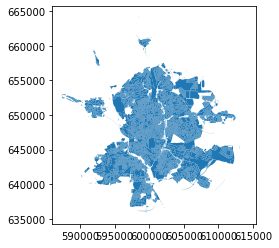

In [6]:
mad_polys = polygonize(mad.geometry)
mad_polys = gpd.GeoDataFrame(geometry = [g for g in mad_polys], crs= mad.crs)
mad_polys.plot()

# Analysing _'selecting_rabs_from_poly'_

In [21]:
#using this to reload module for debugging
import importlib
importlib.reload(rabs)

<module 'rabs_simplify' from '/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/rabs_simplify.py'>

In [25]:
#testing includeing and not including the adacent polys
rab = rabs.selecting_rabs_from_poly(mad_polys, include_adjacent=True)
print('selected polygons\n', len(rab))
rab.head(3)

selected polygons
 1367


,geometry,index_right
356,"POLYGON ((599895.357 645441.472, 599897.468 64...",356
3569,"POLYGON ((599590.624 645365.430, 599580.019 64...",3573
3573,"POLYGON ((599610.333 645290.707, 599602.380 64...",3573


In [28]:
rab_ = rabs.selecting_rabs_from_poly(mad_polys, include_adjacent=False)
print('selected polygons\n', len(rab_))
rab_.head(3)

selected polygons
 639


,geometry,index_right
26,"POLYGON ((607717.202 647660.853, 607713.722 64...",26
33,"POLYGON ((606720.853 648289.500, 606726.488 64...",33
206,"POLYGON ((606461.028 646379.760, 606464.604 64...",206


## Resulting differences

In [24]:
#the overall function seems to work
simpl_adj = rabs.roundabout_simpl(mad, mad_polys, include_adjacent=True)
simpl_noadj = rabs.roundabout_simpl(mad, mad_polys, include_adjacent=False)

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [29]:
# looking at the outputs based on number of adjacent polys (& size/areas)
or_rabs = rab[rab.index == rab.index_right]
or_rabs['area'] = or_rabs.geometry.area
or_rabs["circom"] = mm.CircularCompactness(or_rabs, "area").series
or_rabs['adjacent_polys'] = rab.groupby('index_right')['index_right'].count()-1

sample0 = or_rabs[or_rabs.adjacent_polys == 0].sample(5)
sample2 = or_rabs[(or_rabs.adjacent_polys<=2) & (or_rabs.adjacent_polys >1 )].sample(5)
sample4 = or_rabs[(or_rabs.adjacent_polys<=4) & (or_rabs.adjacent_polys >2 )].sample(5)
sample5 = or_rabs[(or_rabs.adjacent_polys>=5)].sample(5)

sample0.sort_values('area', inplace = True)
sample2.sort_values('area', inplace = True)
sample4.sort_values('area', inplace = True)
sample5.sort_values('area', inplace = True)

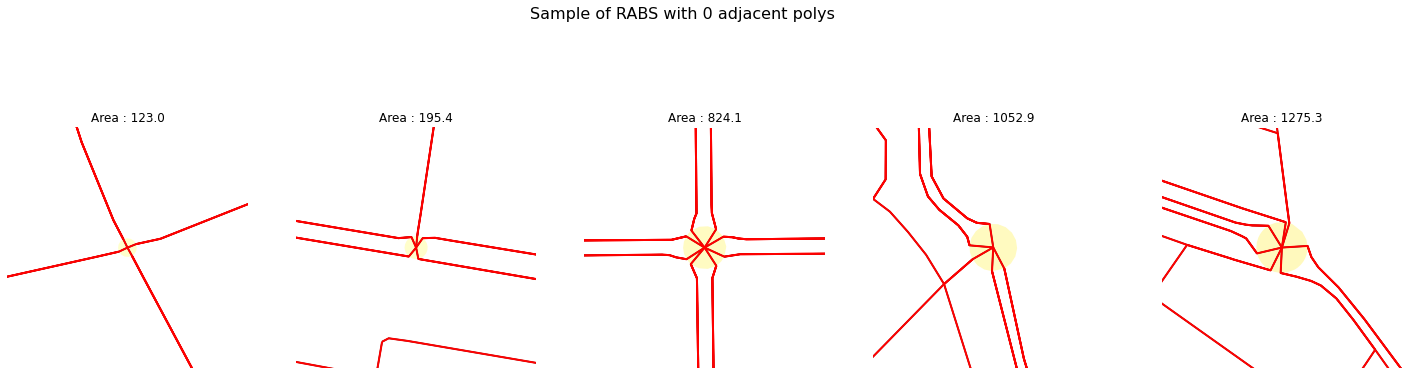

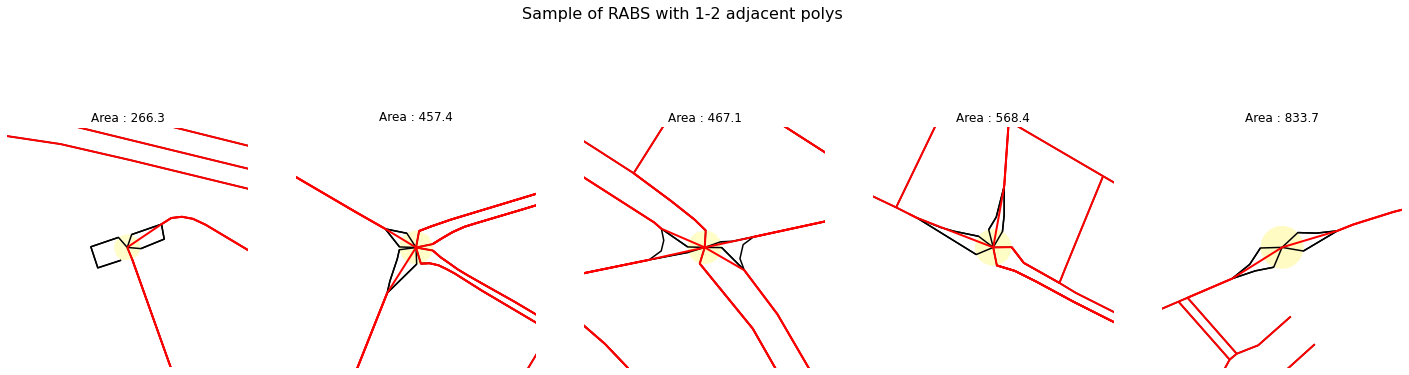

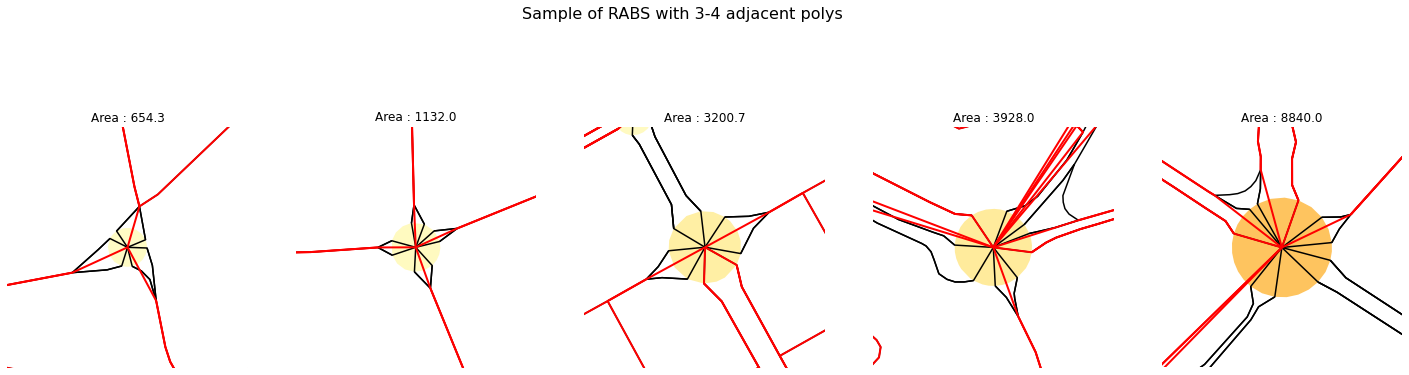

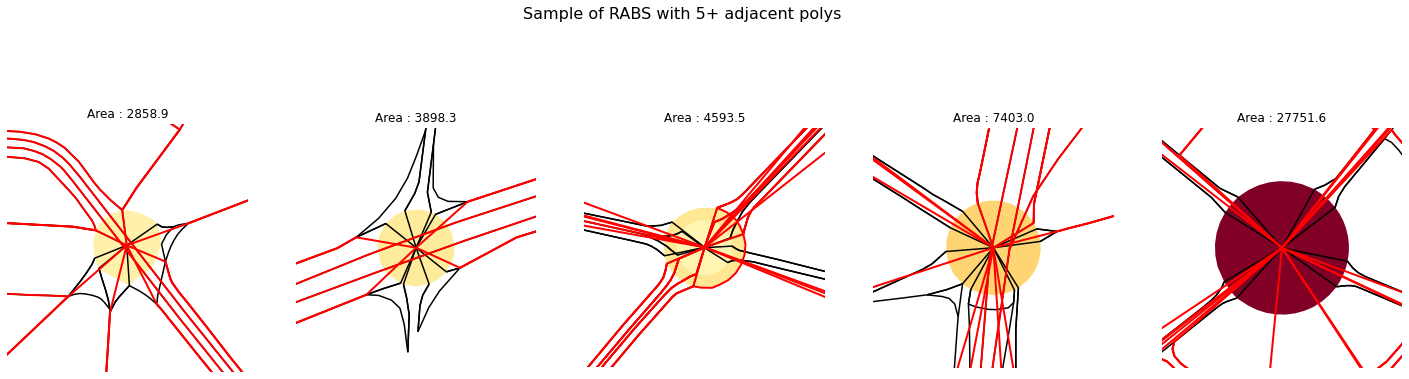

In [127]:
sample_cats = ['0', '1-2', '3-4', '5+']
ls_samples = [sample0, sample2, sample4, sample5]

for i in range(len(ls_samples)):
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 7))
    axs = axs.flatten()
    
    for idx in range(len(ls_samples[i])):
        #establishing limits for each RAB
        minx, miny, maxx, maxy = ls_samples[i].iloc[idx].geometry.bounds

        #plotting rabs
        #rab_plus.plot(ax=axs[idx], color='grey', edgecolor= 'orange')
        or_rabs.plot(ax=axs[idx], column = 'area', cmap= 'YlOrRd')
        simpl_noadj.plot(ax=axs[idx], color='black', linewidth=1.5)
        simpl_adj.plot(ax=axs[idx], color='red', linewidth=2)

        axs[idx].set_xlim(minx-75, maxx+75)
        axs[idx].set_ylim(miny-75, maxy+75)
        axs[idx].axis('off')
        axs[idx].set_title('Area : '+ f"{ls_samples[i].iloc[idx]['area'].round(1)}")

    fig.suptitle('Sample of RABS with ' + sample_cats[i] +' adjacent polys', fontsize=16)
    plt.show()
    

### importat considerations
- Overall, _including polygons_ seems to do a better job than not including them and then expecting further methods
- As the size of polygons increase the number of problems does too.--> need for a threshold size. 
- If including adjacent polygons more development is needed:
    - Adjacent polygons need to consider if they are actually connecting - see case 3 of cat 3-4
- Resolve 'double' round about (i.e. circle within circle - see case 3 of cat 5+)

## calculating percentage of polygons above different thresholds

In [37]:
rab_['area'] = rab_.geometry.area
rab_['circom'] = mm.CircularCompactness(rab_, "area").series
rab_.head(3)

,geometry,index_right,area,circom
26,"POLYGON ((607717.202 647660.853, 607713.722 64...",26,9791.985128,0.945734
33,"POLYGON ((606720.853 648289.500, 606726.488 64...",33,14631.053756,0.989725
206,"POLYGON ((606461.028 646379.760, 606464.604 64...",206,4083.284712,0.989770


In [41]:
#possibele threshoilds
mad_polys_mean = mad_polys.geometry.area.mean()

mad_polys_70perc = mad_polys.area.quantile(0.70)
mad_polys_75perc = mad_polys.area.quantile(0.75)
mad_polys_80perc = mad_polys.area.quantile(0.80)
mad_polys_85perc = mad_polys.area.quantile(0.85)
mad_polys_90perc = mad_polys.area.quantile(0.90)

In [88]:
T_polys = len(mad_polys)

thr_names = ['mean', '70 perc', '75 perc','80 perc','85 perc', '90 perc']
ls = [mad_polys_mean , mad_polys_70perc ,mad_polys_75perc ,mad_polys_80perc ,mad_polys_85perc , mad_polys_90perc ]

for i in range(len(ls)):
    rabs_under = len(rab_[rab_.area <= ls[i]])
    perc_rabs_under = rabs_under / len(rab_)
    
    print( thr_names[i], round(ls[i]), 'sqmt\nTo remove:', len(rab_)-rabs_under , 
          'leaving:',round(perc_rabs_under*100,2),'%\n' )

mean 13779 sqmt
To remove: 6 leaving: 99.06 %

70 perc 9546 sqmt
To remove: 9 leaving: 98.59 %

75 perc 11799 sqmt
To remove: 7 leaving: 98.9 %

80 perc 14788 sqmt
To remove: 2 leaving: 99.69 %

85 perc 18583 sqmt
To remove: 1 leaving: 99.84 %

90 perc 25085 sqmt
To remove: 1 leaving: 99.84 %



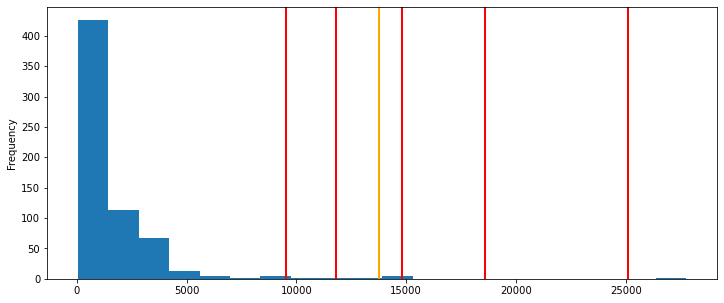

In [89]:
rab_.area.plot.hist(bins = 20, figsize =(12,5))

plt.axvline(ls[0], color='orange', linewidth=2)
plt.axvline(ls[1], color='red', linewidth=2)
plt.axvline(ls[2], color='red', linewidth=2)
plt.axvline(ls[3], color='red', linewidth=2)
plt.axvline(ls[4], color='red', linewidth=2)
plt.axvline(ls[5], color='red', linewidth=2)

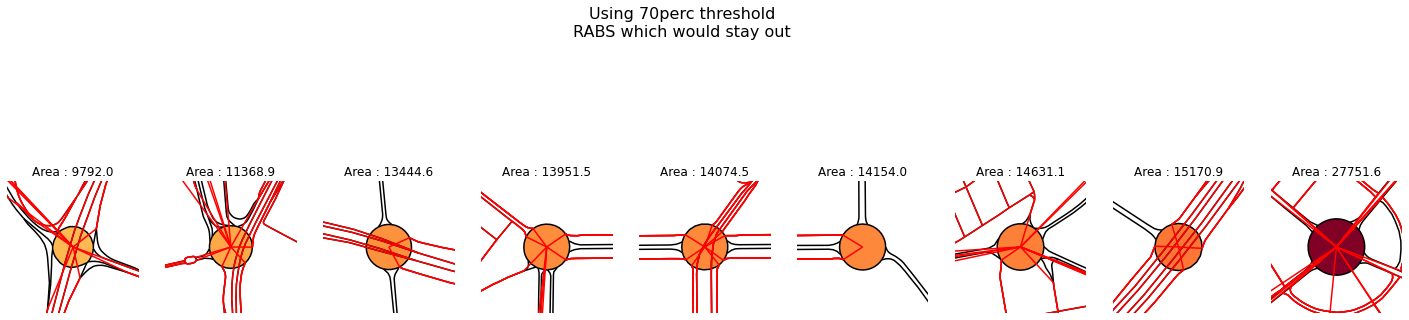

In [123]:
rab_out = rab_[rab_.area >= ls[1]]
rab_out.sort_values('area', inplace = True)
n = len(rab_out)

fig, axs = plt.subplots(1, n, figsize=(25, 7))
axs = axs.flatten()

for i in range(len(rab_out)):
    minx, miny, maxx, maxy = rab_out.iloc[i].geometry.bounds
    
    #plotting rabs
    or_rabs.plot(ax=axs[i], column = 'area', cmap= 'YlOrRd')
    mad.plot(ax=axs[i], color='black', linewidth=1.5)
    simpl_adj.plot(ax=axs[i], color='red', linewidth = 1.5)

    offset = 125
    axs[i].set_xlim(minx-offset, maxx+offset)
    axs[i].set_ylim(miny-offset, maxy+offset)
    axs[i].axis('off')
    axs[i].set_title('Area : ' + f"{rab_out.iloc[i].area.round(1)}")
    
fig.suptitle('Using 70perc threshold\nRABS which would stay out', fontsize=16)
plt.show()

### All are errors in the current way of their simplification ! 
--> MAKES SENSE TO INCLUDE SAID thereshold, if not lower

In [151]:
#what if I lower the threshold back to 0.7 AND limit the selection by size ?! -- 

#getting the first selection independently
rab7 = rabs.selecting_rabs_from_poly(mad_polys, include_adjacent=True , circom_threshold = 0.7 )

#extracting the real RABS
rab_real = rab7[rab7.index == rab7.index_right]

#getting the full output
simpl_adj = rabs.roundabout_simpl(mad, mad_polys, include_adjacent=True, circom_threshold = 0.7)

print('selected polygons', len(rab_real))
print('\nadjacent areas', len(rab7)-len(rab_real))
rab7.head(3)

selected polygons 692

adjacent areas 810


,geometry,index_right
356,"POLYGON ((599895.357 645441.472, 599897.468 64...",356
3569,"POLYGON ((599590.624 645365.430, 599580.019 64...",3573
3573,"POLYGON ((599610.333 645290.707, 599602.380 64...",3573


In [153]:
#adding some attributes
rab7['area'] = rab7.geometry.area
rab7['circom'] = mm.CircularCompactness(rab7, "area").series
#total number of original polygons
T_polys = len(mad_polys)

thr_names = ['mean', '70 perc', '75 perc','80 perc','85 perc', '90 perc']
ls = [mad_polys_mean , mad_polys_70perc ,mad_polys_75perc ,mad_polys_80perc ,mad_polys_85perc , mad_polys_90perc ]

for i in range(len(ls)):
    rabs_under = len(rab_real[rab_real.area <= ls[i]])
    rabs_out = len(rab_real) - rabs_under
    perc_rabs_remaining = (len(rab_real) - rabs_out) / len(rab_real)

    print( thr_names[i], round(ls[i]), 'sqmt\nTo remove:', rabs_out , 
          'leaving:', round(perc_rabs_remaining*100,1) , '%\n' )

mean 13779 sqmt
To remove: 8 leaving: 98.8 %

70 perc 9546 sqmt
To remove: 12 leaving: 98.3 %

75 perc 11799 sqmt
To remove: 9 leaving: 98.7 %

80 perc 14788 sqmt
To remove: 4 leaving: 99.4 %

85 perc 18583 sqmt
To remove: 3 leaving: 99.6 %

90 perc 25085 sqmt
To remove: 2 leaving: 99.7 %



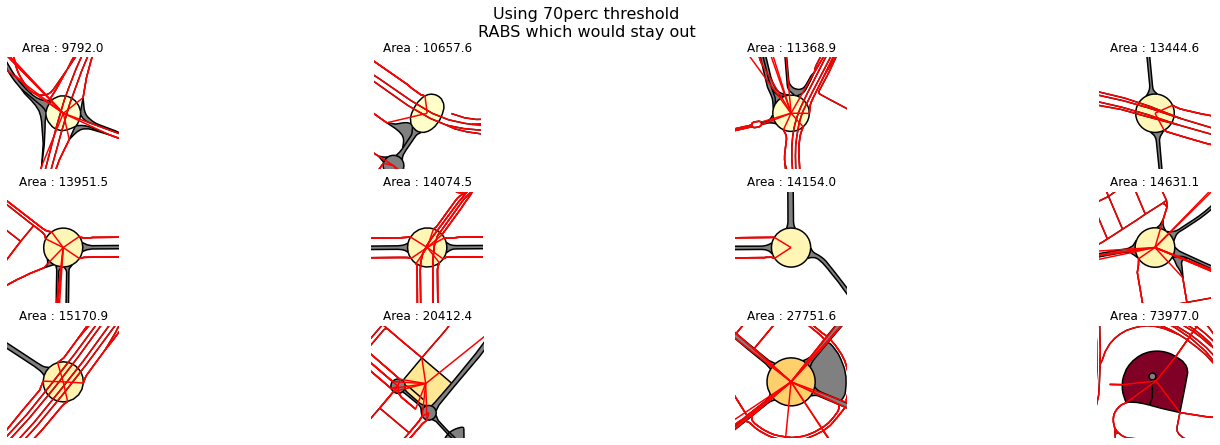

In [174]:
rab_real_out = rab_real[rab_real.geometry.area >= ls[1]]
rab_real_out['area'] = rab_real_out.geometry.area
rab_real_out.sort_values('area', inplace = True)

n = len(rab_real_out)
ratios = (round(np.sqrt(n)), int(np.ceil(np.sqrt(n))) )

fig, axs = plt.subplots(ratios[0], ratios[1], figsize=(20, 15)) 
axs = axs.flatten()

for i in range(len(rab_real_out)):
    minx, miny, maxx, maxy = rab_real_out.iloc[i].geometry.bounds
    
    #plotting rabs
    rab7.plot(ax=axs[i], color = 'grey') # ALL RABS INCLUDING ADJACENTS
    rab_real_out.plot(ax=axs[i], column = 'area', cmap= 'YlOrRd') # ONLY REAL RABS TO POTENTIALLY DISCARD
    mad.plot(ax=axs[i], color='black', linewidth=1.5) # THE ORIGINAL ROAD NETWORK
    simpl_adj.plot(ax=axs[i], color='red', linewidth = 1.5) # THE OUTPUT -LIKELY WRONG- OF SIMPLIFYED ALGO 

    offset = 125
    axs[i].set_xlim(minx-offset, maxx+offset)
    axs[i].set_ylim(miny-offset, maxy+offset)
    axs[i].axis('off')
    axs[i].set_title('Area : ' + f"{rab_real_out.iloc[i].area.round(1)}")
    
fig.suptitle('Using 70perc threshold\nRABS which would stay out', fontsize=16)
plt.show()

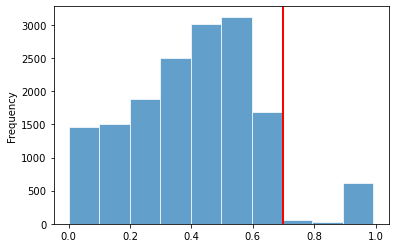

In [182]:
mad_polys.circom.plot.hist(alpha = 0.7, edgecolor = 'white')
plt.axvline(0.7, color='red', linewidth=2)

In [187]:
#are margin between a sensible threshold (85th perc) and the next false positive
next_val = rab_real_out[rab_real_out.area > mad_polys_85perc].iloc[0].area
margin = next_val - mad_polys_85perc
margin

1829.3330496340386

## considerations
- lowering the threshold back to 0.7 seems to make sense because it mostly selects rounabouts
- a sensible area threshold seems to be at the 85th percentile 
    - _which in this case leaves 99.6% of the cases_
    - _the margin (1829.3 sqmt) between the threshold and the following false positive is large enough to consider that other cities could also perform well_

## next steps
- update function **selecting_rabs_from_poly** to create a custom area threshold with *85 percentile* as its default
- adjust the way we are selecting the adjacent polygons